#twristar_train_predict.ipynb
Minimal example to train a model on the scripted portion of the TWRistAR dataset and predict the free-form walking portions.

This is similar to the early work https://github.com/imics-lab/Semi-Supervised-HAR-e4-Wristband/blob/main/Semi-Supervised-HAR.ipynb but uses a much newer version of the loader and is intended to support better assisted labeling.

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

[Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), Texas State University, [IMICS Lab](https://imics.wp.txstate.edu/)  
TODO:
* The order of activities on the scatter plot varies, should be set.



In [1]:
import os
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip

import pandas as pd
import numpy as np
import urllib.request # to get files from web w/o !wget

# to measure and display training time
import time
from datetime import timedelta

# model library and functions
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping

# for one-hot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
def get_py_file(fname, url):
    """checks for local file, if none downloads from URL.    
    :return: nothing"""
    #fname = 'load_data_utils.py'
    #ffname = os.path.join(my_dir,fname)
    if (os.path.exists(fname)):
        print ("Local",fname, "found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve(url, filename=fname)

get_py_file(fname = 'load_data_utils.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py')
get_py_file(fname = 'load_data_transforms.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_transforms.py')
get_py_file(fname = 'twristar_load_dataset.py', url = 'https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/HAR/TWristAR/twristar_load_dataset.py')

In [3]:
import load_data_transforms as xform
import load_data_utils as utils
import twristar_load_dataset as twristar

Local load_data_utils.py found, skipping download
Local load_data_transforms.py found, skipping download


In [4]:
# Put all three subject's scripted activity into training
# The empty test_subj means the test arrays will also be empty.
subj_dict = dict(train_subj = [1,2,3],
                validation_subj = [],
                test_subj = [])
x_train, y_train, x_test, y_test= twristar.twristar_load_dataset( 
                                split_subj = subj_dict,
                                keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                incl_val_group = False)
print(utils.tabulate_numpy_arrays({'x_train':x_train,'y_train':y_train,
                                   'x_test':x_test,'y_test':y_test})) 

Unzipping TWristAR file in . directory
array    shape          data type
-------  -------------  -----------
x_train  (3168, 96, 4)  float32
y_train  (3168, 6)      uint8
x_test   (0, 96, 4)     float32
y_test   (0, 6)         uint8


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Build and Train the model using the scripted portion of the TWRistAR dataset

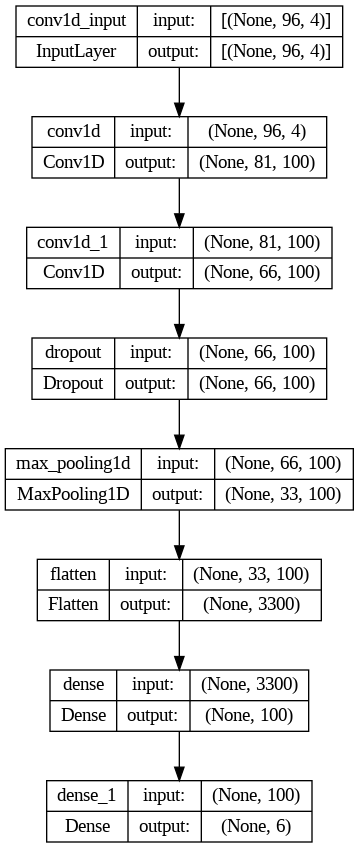

In [5]:
# topology and good article here
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf
# even though this is an interactive notebook, I've put train and test into
# functions hoping this will make it easier to swap models in the future
def build_1D_CNN():
  n_timesteps, n_features, n_outputs = x_train.shape[1], x_train.shape[2], y_train.shape[1]
  model = keras.Sequential(
    [
      layers.Conv1D(filters=100, kernel_size=16, activation='relu',input_shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=100, kernel_size=16, activation='relu'),
      layers.Dropout(0.5),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(100, activation='relu'),
      layers.Dense(n_outputs, activation='softmax')
        ])
  return model 
model = build_1D_CNN()
# model.summary()
# pass rankdir="LR" to plot_model to display sideways
display(keras.utils.plot_model(model, "my_model.png", show_shapes=True))

In [6]:
def train_1D_CNN(model,
    BATCH_SIZE = 32,    # Typical values are 8, 16 or 32
    NUM_EPOCHS = 20): # Educated guess based on experience with this model and TWristAR
    # see https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    history = model.fit(
        x_train,y_train,
        batch_size = BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 1) #0 = silent, 1 = progress bar, 2 = one line per epoch
    return history
start_time = time.time()
history = train_1D_CNN(model)
end_time = time.time()
train_time = timedelta(seconds=(end_time - start_time))
print('Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')

Epoch 1/20
99/99 [==============================] - 12s 87ms/step - loss: 0.6120 - accuracy: 0.7478
Epoch 2/20
99/99 [==============================] - 5s 55ms/step - loss: 0.2868 - accuracy: 0.8974
Epoch 3/20
99/99 [==============================] - 6s 63ms/step - loss: 0.2194 - accuracy: 0.9214
Epoch 4/20
99/99 [==============================] - 5s 55ms/step - loss: 0.1243 - accuracy: 0.9602
Epoch 5/20
99/99 [==============================] - 6s 63ms/step - loss: 0.1022 - accuracy: 0.9694
Epoch 6/20
99/99 [==============================] - 5s 55ms/step - loss: 0.0738 - accuracy: 0.9751
Epoch 7/20
99/99 [==============================] - 6s 63ms/step - loss: 0.0597 - accuracy: 0.9830
Epoch 8/20
99/99 [==============================] - 6s 57ms/step - loss: 0.0495 - accuracy: 0.9867
Epoch 9/20
99/99 [==============================] - 6s 64ms/step - loss: 0.0586 - accuracy: 0.9842
Epoch 10/20
99/99 [==============================] - 5s 55ms/step - loss: 0.0464 - accuracy: 0.9864
Epoch 11

In [7]:
#model.save("my_model") # defaults to newer method with more complex format
model.save("my_h5_model.h5") # the .h5 extension changes the way it is saved.

# Get free-form walks
Due to the nature of the dataset the TWristAR loader has special hooks to process either the scripted data or the unscripted free-form walks

In [8]:
model = [] # nuke it!

In [9]:
twristar.scripted = False # change dataset param to get free-form walks instead
print("Get TWristAR Free-Form Walks - Test = Sub1, Train = Sub2\n")
x_train, y_train, x_test, y_test, log_accelxyz\
                            = twristar.twristar_load_dataset(
                                split_subj = dict (train_subj = [1],
                                                validation_subj = [],
                                                test_subj = [2]),
                                keep_channel_list = ['accel_x', 'accel_y', 'accel_z', 'accel_ttl'],
                                return_info_dict = True,
                                suppress_warn = True)
print(utils.tabulate_numpy_arrays({'x_train': x_train, 'y_train': y_train,
                                'x_test': x_test, 'y_test': y_test}))
twristar.scripted = True   # put it back where you found it!

Get TWristAR Free-Form Walks - Test = Sub1, Train = Sub2

array    shape         data type
-------  ------------  -----------
x_train  (660, 96, 4)  float32
y_train  (660, 6)      uint8
x_test   (736, 96, 4)  float32
y_test   (736, 6)      uint8


/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
#@title Select Subject for Free-Form Walk
sub_num = "Subject 1" #@param ["Subject 1","Subject 2"]

if (sub_num == "Subject 1"):
    x_ff = x_train
    y_ff = y_train
if (sub_num == "Subject 2"):
    x_ff = x_test
    y_ff = y_test

In [11]:
model = keras.models.load_model("my_h5_model.h5")
predictions = model.predict(x_ff, verbose=0,batch_size=32)

#want to use values not one-hot encoding, use argmax to convert
y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
y_ff = np.argmax(y_ff, axis=-1) # axis=-1 means last axis

# reshape again
y_pred = y_pred.reshape((-1, 1)) # reshape from (__,) to (__,1)
y_ff = y_ff.reshape((-1, 1)) # reshape from (__,) to (__,1)

In [12]:
# Convert ints back into strings
y_pred = xform.get_ir2_y_string_labels(y_pred, label_map = twristar.label_map_twristar)
y_ff = xform.get_ir2_y_string_labels(y_ff, label_map = twristar.label_map_twristar)

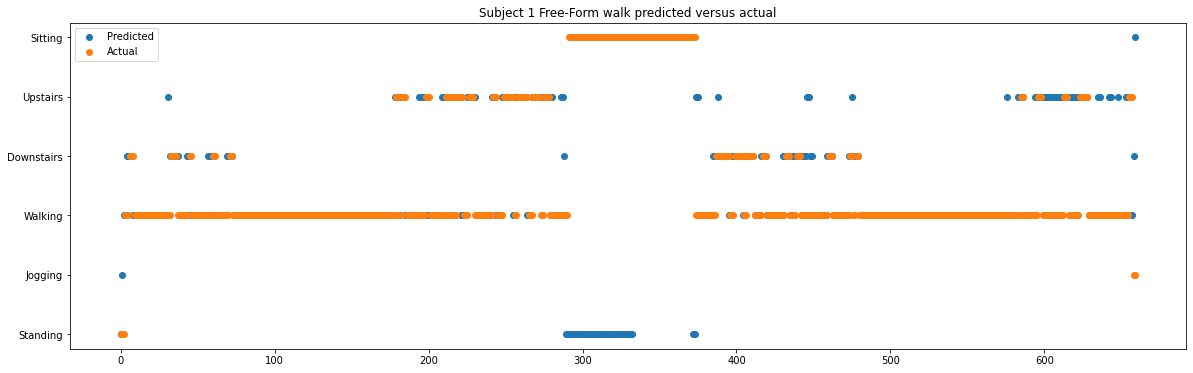

In [16]:
import matplotlib.pyplot as plt
# I never know if better to make a fig and modify or just have commands...
plt.rcParams["figure.figsize"] = (20,6) 
plt.title(sub_num + " Free-Form walk predicted versus actual")
x_values = range(x_ff.shape[0])
plt.scatter(x_values,y_pred[:,0], label="Predicted")
plt.scatter(x_values,y_ff[:,0], label = "Actual")
plt.legend(loc="upper left")